# Part 3: RNN for Sequence Prediction

In [85]:
# Setup
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

BASE = '/content/drive/MyDrive/hw2'
SAVE = f'{BASE}/saved'
CKPT = f'{SAVE}/checkpoints'
DATA = f'{BASE}/data'
for d in [BASE, SAVE, CKPT, DATA]:
    os.makedirs(d, exist_ok=True)

!pip install yfinance opendatasets -q
import yfinance as yf

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
torch.manual_seed(42)
np.random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu


In [86]:
# Dataset and Model
class SeqDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = np.asarray(data).flatten().astype(np.float32)
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) - self.seq_len
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        return torch.tensor(x).unsqueeze(-1), torch.tensor(y)

class RNN(nn.Module):
    def __init__(self, hidden=64, layers=2):
        super().__init__()
        self.hidden = hidden
        self.layers = layers
        self.rnn = nn.RNN(1, hidden, layers, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        h0 = torch.zeros(self.layers, x.size(0), self.hidden).to(x.device)
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :]).squeeze(-1)

def ensure_dirs():
    for d in [SAVE, CKPT]:
        os.makedirs(d, exist_ok=True)

def train_rnn(model, train_ld, val_ld, epochs, name):
    model_path = f'{SAVE}/{name}_model.pt'
    hist_path = f'{SAVE}/{name}_hist.pkl'
    ckpt_path = f'{CKPT}/{name}_ckpt.pt'

    if os.path.exists(model_path) and os.path.exists(hist_path):
        print(f'[{name}] Loading saved model...')
        model.load_state_dict(torch.load(model_path, map_location=device))
        with open(hist_path, 'rb') as f:
            hist = pickle.load(f)
        print(f'[{name}] Done. train={hist["train"][-1]:.6f}')
        return hist

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    hist = {'train': [], 'val': []}
    start = 0

    if os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt['model'])
        optimizer.load_state_dict(ckpt['optim'])
        hist = ckpt['hist']
        start = ckpt['epoch'] + 1

    for ep in range(start, epochs):
        model.train()
        loss_sum = 0
        for x, y in train_ld:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
        train_loss = loss_sum / len(train_ld)

        val_loss = 0
        if val_ld:
            model.eval()
            with torch.no_grad():
                for x, y in val_ld:
                    x, y = x.to(device), y.to(device)
                    val_loss += criterion(model(x), y).item()
            val_loss /= len(val_ld)

        hist['train'].append(train_loss)
        hist['val'].append(val_loss)
        print(f'[{name}] Epoch {ep+1}/{epochs}: train={train_loss:.6f}, val={val_loss:.6f}')

        ensure_dirs()
        torch.save({'epoch': ep, 'model': model.state_dict(), 'optim': optimizer.state_dict(), 'hist': hist}, ckpt_path)

    ensure_dirs()
    torch.save(model.state_dict(), model_path)
    with open(hist_path, 'wb') as f:
        pickle.dump(hist, f)
    if os.path.exists(ckpt_path):
        os.remove(ckpt_path)
    return hist

## Part 3a: Dow Jones Prediction

In [87]:
# Download DJI data using yfinance, save as CSV
dji_path = f'{DATA}/dji.csv'
if os.path.exists(dji_path):
    dji = pd.read_csv(dji_path)
else:
    raw = yf.download('^DJI', start='2010-01-01', end='2024-12-31', progress=False)
    if isinstance(raw.columns, pd.MultiIndex):
        raw.columns = raw.columns.get_level_values(0)
    dji = raw.reset_index()
    dji.to_csv(dji_path, index=False)
print(f'Shape: {dji.shape}')
dji.head()

Shape: (3773, 6)


,Date,Close,High,Low,Open,Volume
0,2010-01-04,10583.959961,10604.969727,10430.690430,10430.690430,179780000
1,2010-01-05,10572.019531,10584.559570,10522.519531,10584.559570,188540000
2,2010-01-06,10573.679688,10594.990234,10546.549805,10564.719727,186040000
3,2010-01-07,10606.860352,10612.370117,10505.209961,10571.110352,217390000
4,2010-01-08,10618.190430,10619.400391,10554.330078,10606.400391,172710000


In [88]:
# Use daily high column, normalize
high = dji['High'].values.astype(np.float32).flatten()
high = high[~np.isnan(high)]
high_min, high_max = high.min(), high.max()
high_norm = (high - high_min) / (high_max - high_min)
print(f'Data points: {len(high)}, Range: {high_min:.0f} - {high_max:.0f}')

Data points: 3773, Range: 9771 - 45074


In [89]:
# Train/val/test split (70/15/15)
SEQ = 100
n = len(high_norm)
train_n, val_n = int(n*0.7), int(n*0.85)
train_d = high_norm[:train_n]
val_d = high_norm[train_n:val_n]
test_d = high_norm[val_n:]

train_ld = DataLoader(SeqDataset(train_d, SEQ), 32, shuffle=True)
val_ld = DataLoader(SeqDataset(val_d, SEQ), 32)
test_ld = DataLoader(SeqDataset(test_d, SEQ), 32)
print(f'Train: {len(train_d)}, Val: {len(val_d)}, Test: {len(test_d)}')

Train: 2641, Val: 566, Test: 566


In [90]:
# Train RNN to predict 101st value from 100 values
dji_model = RNN(hidden=64, layers=2).to(device)
dji_hist = train_rnn(dji_model, train_ld, val_ld, epochs=50, name='dji')

[dji] Loading saved model...
[dji] Done. train=0.000040


In [91]:
# Evaluate on test set
dji_model.eval()
dji_pred, dji_act = [], []
with torch.no_grad():
    for x, y in test_ld:
        dji_pred.extend(dji_model(x.to(device)).cpu().numpy())
        dji_act.extend(y.numpy())
dji_pred, dji_act = np.array(dji_pred), np.array(dji_act)
dji_mse = np.mean((dji_pred - dji_act)**2)
print(f'DJI Test MSE: {dji_mse:.6f}')

DJI Test MSE: 0.000182


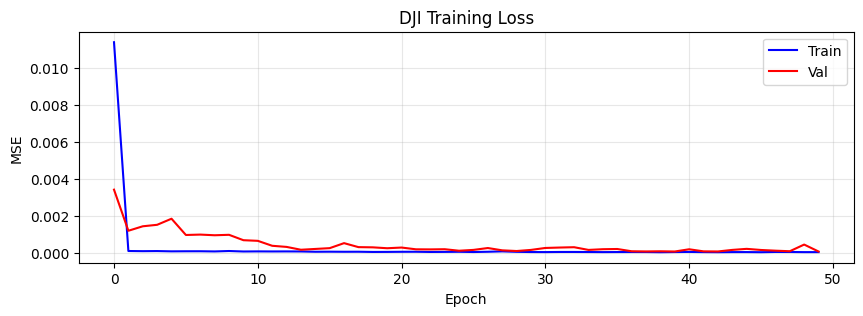

In [92]:
# Plot train/test loss
plt.figure(figsize=(10, 3))
plt.plot(dji_hist['train'], 'b-', label='Train')
plt.plot(dji_hist['val'], 'r-', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('DJI Training Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f'{SAVE}/p3a_dji_loss.png', dpi=150, bbox_inches='tight')
plt.show()

### Compare with sin(x)

In [93]:
# Generate sin(x) data
x_sin = np.linspace(0, 100*np.pi, 5000)
sin_raw = np.sin(x_sin).astype(np.float32)
sin_norm = (sin_raw + 1) / 2

n_s = len(sin_norm)
train_s = sin_norm[:int(n_s*0.7)]
val_s = sin_norm[int(n_s*0.7):int(n_s*0.85)]
test_s = sin_norm[int(n_s*0.85):]

train_s_ld = DataLoader(SeqDataset(train_s, SEQ), 32, shuffle=True)
val_s_ld = DataLoader(SeqDataset(val_s, SEQ), 32)
test_s_ld = DataLoader(SeqDataset(test_s, SEQ), 32)

In [94]:
# Train on sin(x)
sin_model = RNN(hidden=64, layers=2).to(device)
sin_hist = train_rnn(sin_model, train_s_ld, val_s_ld, epochs=50, name='sin')

[sin] Loading saved model...
[sin] Done. train=0.000002


In [95]:
# Evaluate sin model
sin_model.eval()
sin_pred, sin_act = [], []
with torch.no_grad():
    for x, y in test_s_ld:
        sin_pred.extend(sin_model(x.to(device)).cpu().numpy())
        sin_act.extend(y.numpy())
sin_pred, sin_act = np.array(sin_pred), np.array(sin_act)
sin_mse = np.mean((sin_pred - sin_act)**2)
print(f'Sin Test MSE: {sin_mse:.6f}')

Sin Test MSE: 0.000001


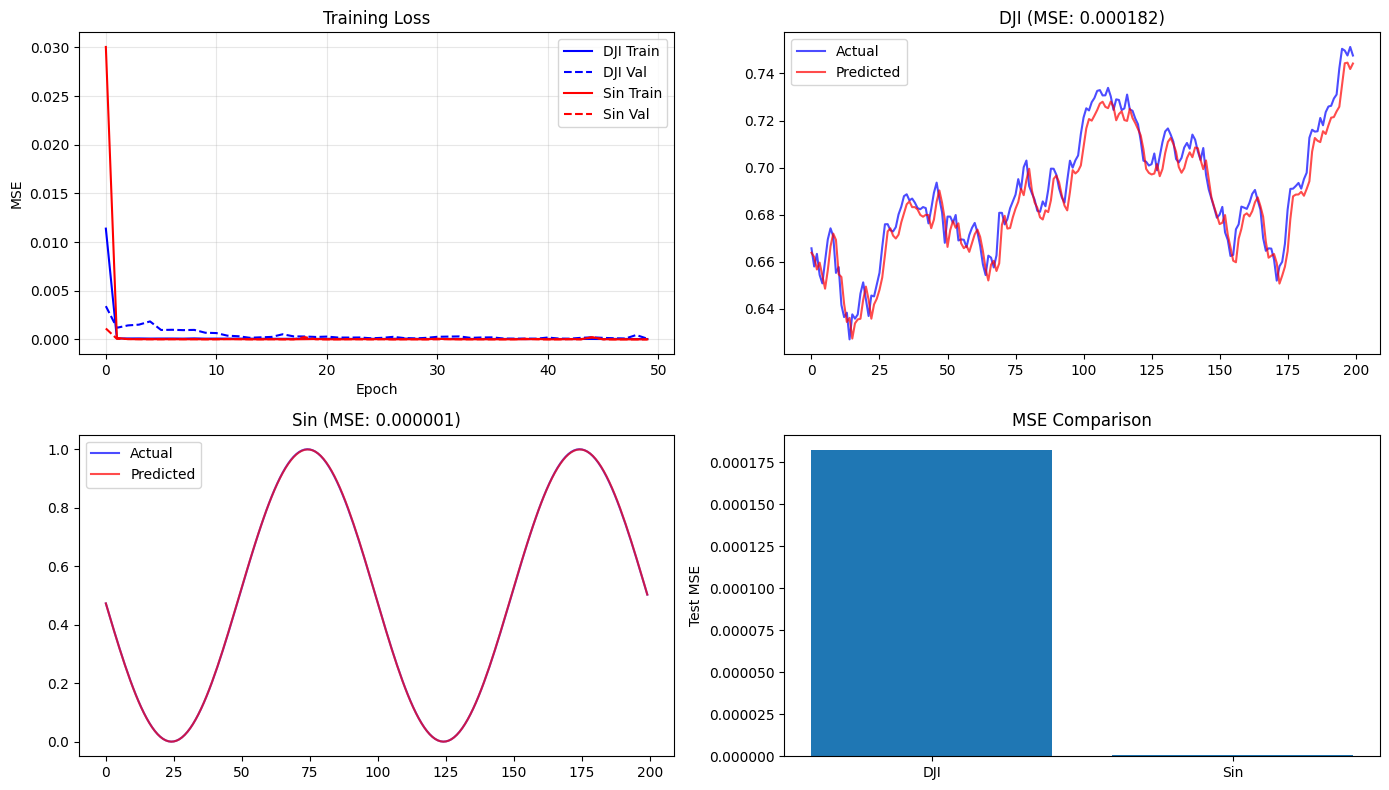


DJI MSE: 0.000182
Sin MSE: 0.000001
Ratio: 253.2x


In [96]:
# Comparison plot
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

ax[0,0].plot(dji_hist['train'], 'b-', label='DJI Train')
ax[0,0].plot(dji_hist['val'], 'b--', label='DJI Val')
ax[0,0].plot(sin_hist['train'], 'r-', label='Sin Train')
ax[0,0].plot(sin_hist['val'], 'r--', label='Sin Val')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('MSE')
ax[0,0].set_title('Training Loss')
ax[0,0].legend()
ax[0,0].grid(alpha=0.3)

ax[0,1].plot(dji_act[:200], 'b-', label='Actual', alpha=0.7)
ax[0,1].plot(dji_pred[:200], 'r-', label='Predicted', alpha=0.7)
ax[0,1].set_title(f'DJI (MSE: {dji_mse:.6f})')
ax[0,1].legend()

ax[1,0].plot(sin_act[:200], 'b-', label='Actual', alpha=0.7)
ax[1,0].plot(sin_pred[:200], 'r-', label='Predicted', alpha=0.7)
ax[1,0].set_title(f'Sin (MSE: {sin_mse:.6f})')
ax[1,0].legend()

ax[1,1].bar(['DJI', 'Sin'], [dji_mse, sin_mse])
ax[1,1].set_ylabel('Test MSE')
ax[1,1].set_title('MSE Comparison')

plt.tight_layout()
plt.savefig(f'{SAVE}/p3a_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nDJI MSE: {dji_mse:.6f}')
print(f'Sin MSE: {sin_mse:.6f}')
print(f'Ratio: {dji_mse/sin_mse:.1f}x')

### Part 3a: Analysis

**Are the results different from sin(x)? Why?**

Yes, the RNN performs much better on sin(x) than on DJI:

1. **sin(x) is deterministic and periodic** - the pattern repeats exactly, so the RNN can learn it perfectly.

2. **Stock prices are non-stationary** - the statistical properties change over time (market regime changes, economic events). What the model learns from 2010-2020 may not apply to 2021-2024.

3. **Stock prices depend on external factors** not present in the price history (news, earnings, sentiment). The RNN only sees past prices, but price changes are driven by events outside this sequence.

## Part 3b: Seattle Weather Data

In [97]:
# Download weather data from Kaggle
weather_path = f'{DATA}/seattle-weather.csv'
if os.path.exists(weather_path):
    print('Loading cached data...')
else:
    with open(f'{BASE}/kaggle_token.txt', 'r') as f:
        os.environ['KAGGLE_API_TOKEN'] = f.read().strip()
    import opendatasets as od
    od.download('https://www.kaggle.com/datasets/ananthr1/weather-prediction', data_dir='/content')
    shutil.copy('/content/weather-prediction/seattle-weather.csv', weather_path)

weather = pd.read_csv(weather_path)
print(f'Shape: {weather.shape}')
weather.head()

Loading cached data...
Shape: (1461, 6)


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


### Part 3b-i: DFT Analysis

In [98]:
temp = weather['temp_max'].values.astype(np.float32)
one_yr = temp[:365]
three_yr = temp[:1095]
print(f'1 year: {len(one_yr)}, 3 years: {len(three_yr)}')

1 year: 365, 3 years: 1095


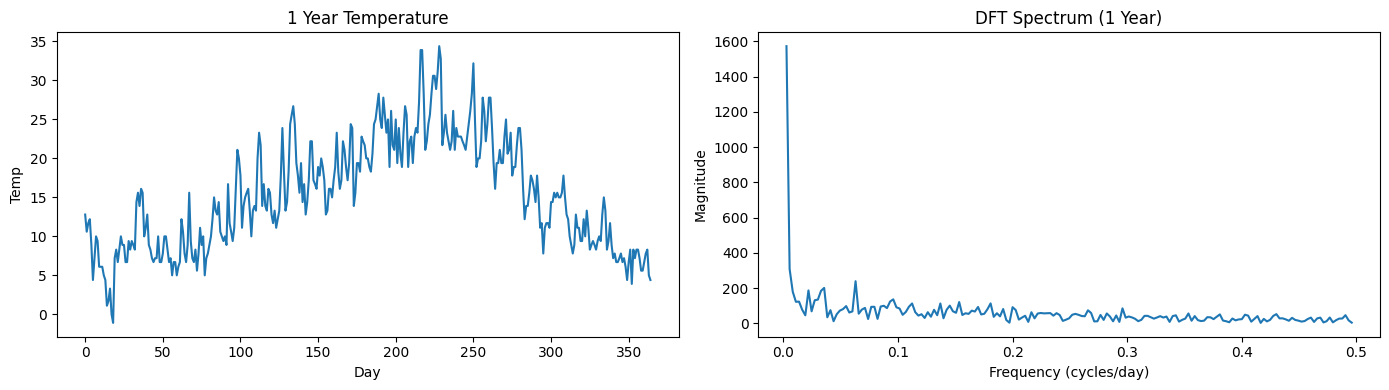


Top frequencies (1 year):
  Period: 365.0 days, Magnitude: 1572.6
  Period: 182.5 days, Magnitude: 308.3
  Period: 15.9 days, Magnitude: 239.3
  Period: 28.1 days, Magnitude: 201.1
  Period: 45.6 days, Magnitude: 186.9


In [99]:
# DFT on 1 year
fft1 = np.fft.fft(one_yr)
freq1 = np.fft.fftfreq(len(one_yr), d=1)
mag1 = np.abs(fft1[:len(one_yr)//2])
freq1_pos = freq1[:len(one_yr)//2]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(one_yr)
ax[0].set_title('1 Year Temperature')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('Temp')

ax[1].plot(freq1_pos[1:], mag1[1:])
ax[1].set_title('DFT Spectrum (1 Year)')
ax[1].set_xlabel('Frequency (cycles/day)')
ax[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.savefig(f'{SAVE}/p3b_dft_1yr.png', dpi=150, bbox_inches='tight')
plt.show()

top1 = np.argsort(mag1[1:])[-5:] + 1
print('\nTop frequencies (1 year):')
for i in reversed(top1):
    p = 1/freq1_pos[i] if freq1_pos[i] != 0 else float('inf')
    print(f'  Period: {p:.1f} days, Magnitude: {mag1[i]:.1f}')

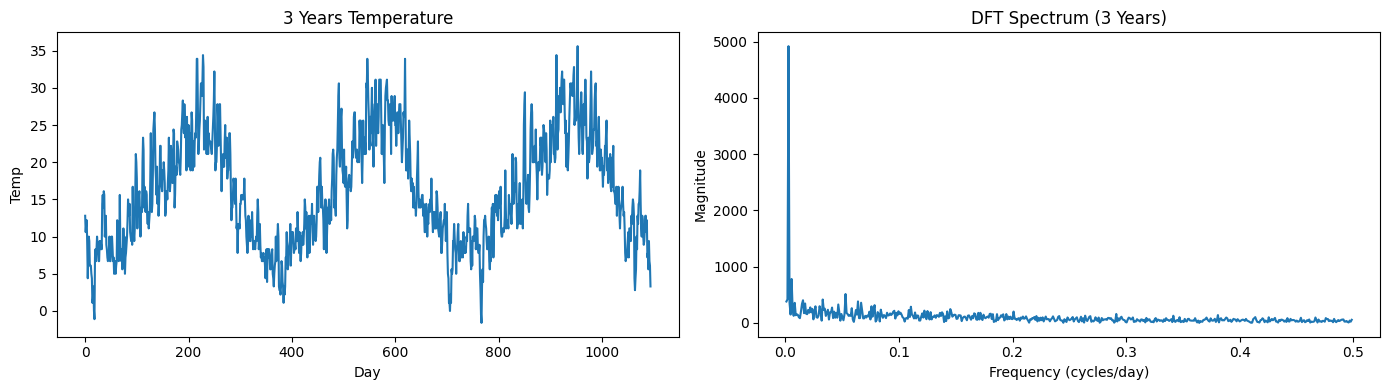


Top frequencies (3 years):
  Period: 365.0 days, Magnitude: 4918.1
  Period: 182.5 days, Magnitude: 781.7
  Period: 18.9 days, Magnitude: 514.1
  Period: 547.5 days, Magnitude: 418.8
  Period: 30.4 days, Magnitude: 416.6


In [100]:
# DFT on 3 years
fft3 = np.fft.fft(three_yr)
freq3 = np.fft.fftfreq(len(three_yr), d=1)
mag3 = np.abs(fft3[:len(three_yr)//2])
freq3_pos = freq3[:len(three_yr)//2]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(three_yr)
ax[0].set_title('3 Years Temperature')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('Temp')

ax[1].plot(freq3_pos[1:], mag3[1:])
ax[1].set_title('DFT Spectrum (3 Years)')
ax[1].set_xlabel('Frequency (cycles/day)')
ax[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.savefig(f'{SAVE}/p3b_dft_3yr.png', dpi=150, bbox_inches='tight')
plt.show()

top3 = np.argsort(mag3[1:])[-5:] + 1
print('\nTop frequencies (3 years):')
for i in reversed(top3):
    p = 1/freq3_pos[i] if freq3_pos[i] != 0 else float('inf')
    print(f'  Period: {p:.1f} days, Magnitude: {mag3[i]:.1f}')

### Part 3b-i: Analysis

**Do you see periodicity?**

Yes, both 1-year and 3-year DFT show a dominant frequency corresponding to ~365 days (annual cycle). This is the seasonal pattern - temperatures are higher in summer, lower in winter.

With 3 years of data, the same annual periodicity appears with ~3x magnitude (3 repetitions of the cycle) and finer frequency resolution due to more data points.

### Part 3b-ii: Weather Prediction

In [101]:
# Train on 2 years, predict year 3
train_w = temp[:730].astype(np.float32)
test_w = temp[730:1095].astype(np.float32)

w_min, w_max = train_w.min(), train_w.max()
train_w_n = (train_w - w_min) / (w_max - w_min)
test_w_n = (test_w - w_min) / (w_max - w_min)

print(f'Train: {len(train_w)} days, Test: {len(test_w)} days')

Train: 730 days, Test: 365 days


In [102]:
# Train weather model
W_SEQ = 30
train_w_ld = DataLoader(SeqDataset(train_w_n, W_SEQ), 32, shuffle=True)
w_model = RNN(hidden=32, layers=1).to(device)
w_hist = train_rnn(w_model, train_w_ld, None, epochs=100, name='weather')

[weather] Loading saved model...
[weather] Done. train=0.005682


In [103]:
# Predict year 3
w_model.eval()
all_w = np.concatenate([train_w_n, test_w_n])
preds = []

with torch.no_grad():
    for i in range(len(test_w)):
        seq = all_w[730-W_SEQ+i : 730+i]
        x = torch.tensor(seq).unsqueeze(0).unsqueeze(-1).float().to(device)
        preds.append(w_model(x).item())

preds = np.array(preds)
preds_denorm = preds * (w_max - w_min) + w_min

mae = np.mean(np.abs(preds_denorm - test_w))
rmse = np.sqrt(np.mean((preds_denorm - test_w)**2))
print(f'MAE: {mae:.2f} degrees')
print(f'RMSE: {rmse:.2f} degrees')

MAE: 2.25 degrees
RMSE: 2.85 degrees


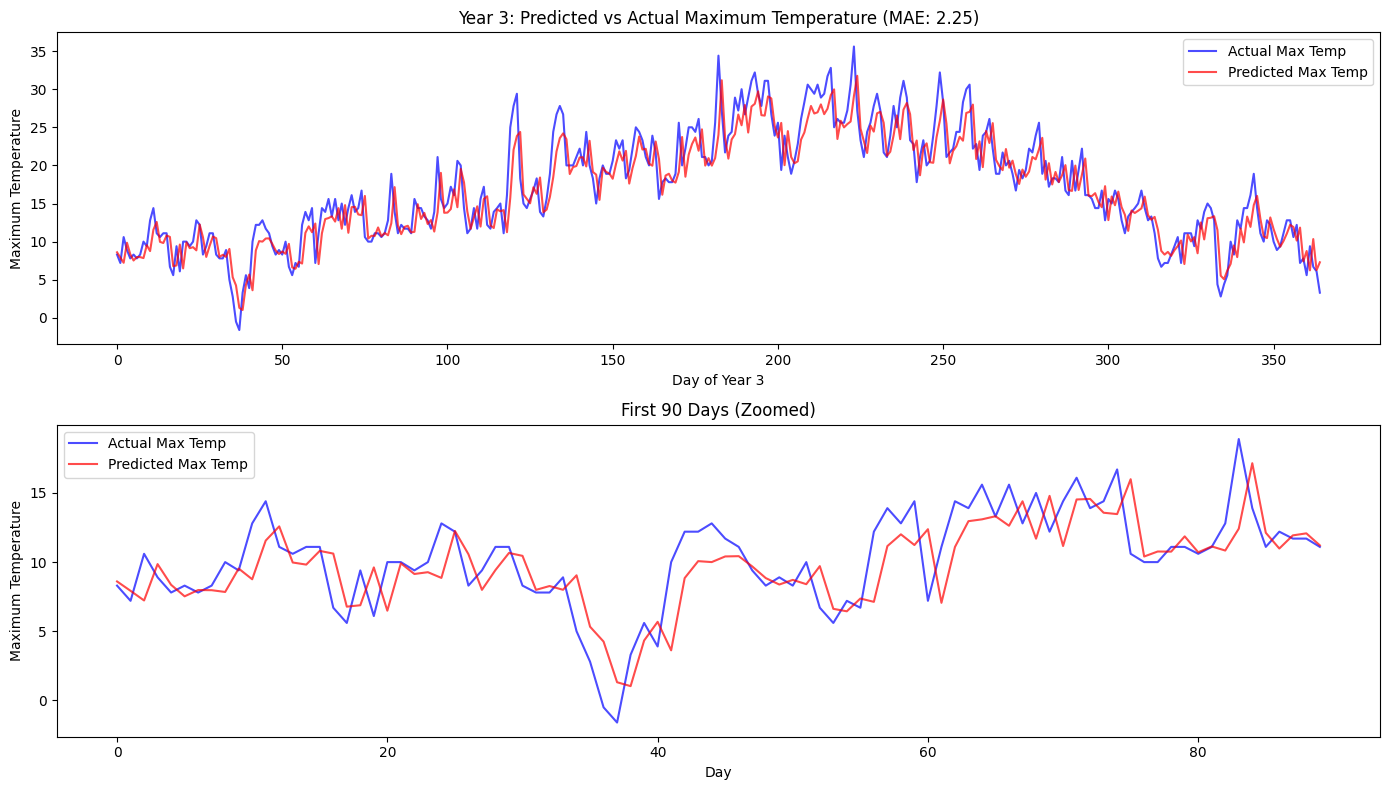

In [104]:
# Plot predictions vs actual maximum temperature
fig, ax = plt.subplots(2, 1, figsize=(14, 8))

ax[0].plot(test_w, 'b-', label='Actual Max Temp', alpha=0.7)
ax[0].plot(preds_denorm, 'r-', label='Predicted Max Temp', alpha=0.7)
ax[0].set_xlabel('Day of Year 3')
ax[0].set_ylabel('Maximum Temperature')
ax[0].set_title(f'Year 3: Predicted vs Actual Maximum Temperature (MAE: {mae:.2f})')
ax[0].legend()

ax[1].plot(test_w[:90], 'b-', label='Actual Max Temp', alpha=0.7)
ax[1].plot(preds_denorm[:90], 'r-', label='Predicted Max Temp', alpha=0.7)
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Maximum Temperature')
ax[1].set_title('First 90 Days (Zoomed)')
ax[1].legend()

plt.tight_layout()
plt.savefig(f'{SAVE}/p3b_weather_pred.png', dpi=150, bbox_inches='tight')
plt.show()

### Part 3b-ii: Analysis

**What do you observe and why?**

1. The model captures the **seasonal trend** - predicting higher temps in summer, lower in winter. The RNN's hidden state learns to encode the time of year from the input sequence.

2. **Day-to-day predictions have error** because weather has short-term variability (fronts, storms) that can't be predicted from temperature history alone.

3. The RNN learned the **yearly pattern** but cannot predict random daily fluctuations. This is expected - the model only sees past temperatures, but daily weather depends on factors not in our input (pressure systems, humidity).

**How the model was trained and used:**
- Trained on 2 years (730 days) of max temperature data
- For each day of year 3, we feed the previous 30 days as input and predict the next day's max temperature
- The RNN uses its hidden state to capture temporal patterns from the sequence

In [105]:
# Summary
print('Saved files:')
for f in sorted(os.listdir(SAVE)):
    if f.startswith('p3'):
        print(f'  {f}')

Saved files:
  p3a_comparison.png
  p3a_dji_data.png
  p3a_dji_loss.png
  p3a_dji_pred.png
  p3b_dft_1yr.png
  p3b_dft_3yr.png
  p3b_weather_pred.png
